In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/ECS189/ECS189G-Project/local_code')
sys.path.append('/content/drive/MyDrive/ECS189/ECS189G-Project/local_code/stage_3_code')


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader, TensorDataset
from stage_3_code.script_data_loader import load_data  # This function must load each dataset properly


In [ ]:
class StrongCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(StrongCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Use dummy input to compute flattened size
        # Dynamically get the input shape from training data
        dummy_input = torch.zeros(1, *X_train.shape[1:])

        out_feat = self.features(dummy_input)
        self.flattened_size = out_feat.view(1, -1).shape[1]

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Flatten(),
            nn.Linear(self.flattened_size, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [ ]:
def train_model(model, train_loader, test_loader, epochs=10, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Evaluate test accuracy at this epoch
        model.eval()
        correct = total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        accuracy = correct / total
        test_accuracies.append(accuracy)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Test Acc: {accuracy:.4f}")

    return model, train_losses, test_accuracies



In [ ]:
def evaluate_model(model, test_loader):
    device = next(model.parameters()).device  # get the device the model is on
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    report = classification_report(all_labels, all_preds, output_dict=True)
    return report


In [ ]:
# Ablation CNN: fewer filters, no dropout, no batch norm
class AblationCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(AblationCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Dynamically get the input shape from training data
        dummy_input = torch.zeros(1, *X_train.shape[1:])

        out_feat = self.features(dummy_input)
        self.flattened_size = out_feat.view(1, -1).shape[1]

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flattened_size, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x



--- Running on ORL Dataset ---
ORL label values — min: 0, max: 39, num_classes: 40
Epoch [1/50], Loss: 7.6145, Test Acc: 0.0500
Epoch [2/50], Loss: 4.1128, Test Acc: 0.0750
Epoch [3/50], Loss: 1.8834, Test Acc: 0.0500
Epoch [4/50], Loss: 0.8931, Test Acc: 0.0250
Epoch [5/50], Loss: 0.3898, Test Acc: 0.0750
Epoch [6/50], Loss: 0.1551, Test Acc: 0.1000
Epoch [7/50], Loss: 0.0707, Test Acc: 0.2000
Epoch [8/50], Loss: 0.0421, Test Acc: 0.5000
Epoch [9/50], Loss: 0.0211, Test Acc: 0.8000
Epoch [10/50], Loss: 0.0136, Test Acc: 0.9250
Epoch [11/50], Loss: 0.0107, Test Acc: 0.9500
Epoch [12/50], Loss: 0.0086, Test Acc: 1.0000
Epoch [13/50], Loss: 0.0069, Test Acc: 1.0000
Epoch [14/50], Loss: 0.0058, Test Acc: 1.0000
Epoch [15/50], Loss: 0.0056, Test Acc: 1.0000
Epoch [16/50], Loss: 0.0043, Test Acc: 1.0000
Epoch [17/50], Loss: 0.0041, Test Acc: 1.0000
Epoch [18/50], Loss: 0.0038, Test Acc: 1.0000
Epoch [19/50], Loss: 0.0033, Test Acc: 1.0000
Epoch [20/50], Loss: 0.0030, Test Acc: 1.0000
Epoch

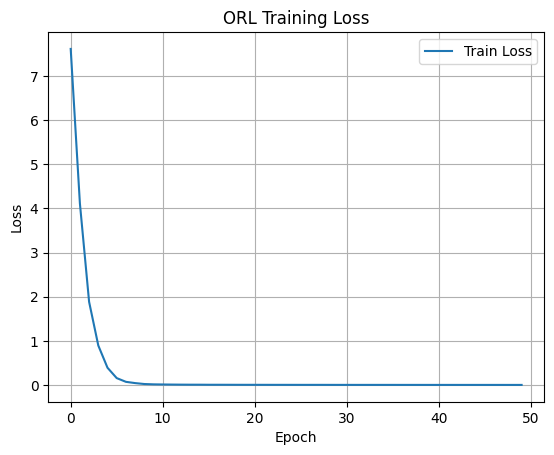

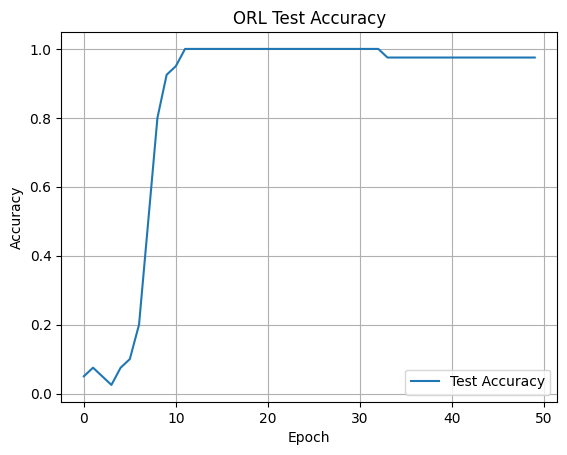

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ORL Evaluation Report:
Accuracy: 0.9750
Precision: 0.9625
Recall: 0.9750
F1-Score: 0.9667

--- Ablation: Running on ORL Dataset ---
Epoch [1/30], Loss: 3.7159, Test Acc: 0.0500
Epoch [2/30], Loss: 3.6346, Test Acc: 0.0750
Epoch [3/30], Loss: 3.4488, Test Acc: 0.0750
Epoch [4/30], Loss: 3.0930, Test Acc: 0.2750
Epoch [5/30], Loss: 2.5163, Test Acc: 0.4000
Epoch [6/30], Loss: 1.7678, Test Acc: 0.5750
Epoch [7/30], Loss: 1.1270, Test Acc: 0.6750
Epoch [8/30], Loss: 0.6658, Test Acc: 0.8000
Epoch [9/30], Loss: 0.3791, Test Acc: 0.8000
Epoch [10/30], Loss: 0.2044, Test Acc: 0.8750
Epoch [11/30], Loss: 0.1086, Test Acc: 0.8750
Epoch [12/30], Loss: 0.0705, Test Acc: 0.8750
Epoch [13/30], Loss: 0.0550, Test Acc: 0.9000
Epoch [14/30], Loss: 0.0326, Test Acc: 0.9500
Epoch [15/30], Loss: 0.0245, Test Acc: 0.9750
Epoch [16/30], Loss: 0.0163, Test Acc: 0.9250
Epoch [17/30], Loss: 0.0086, Test Acc: 0.9750
Epoch [18/30], Loss: 0.0080, Test Acc: 0.9750
Epoch [19/30], Loss: 0.0050, Test Acc: 0.9500
Epo

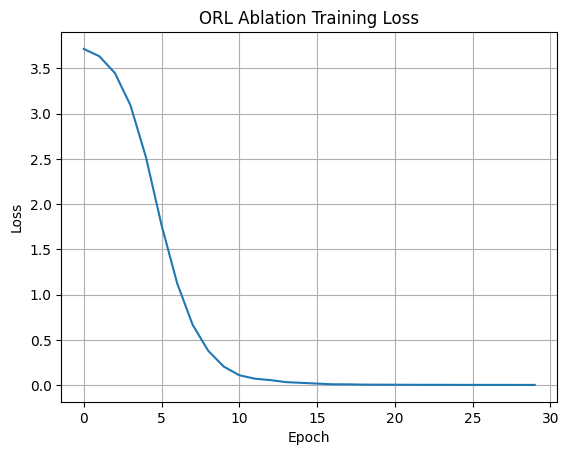

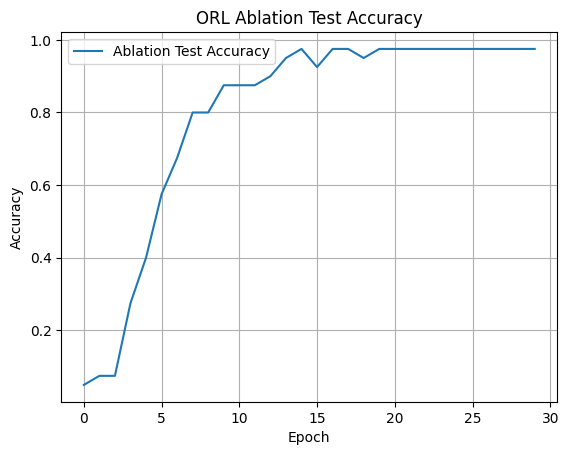

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ORL Ablation Evaluation Report:
Accuracy: 0.9750
Precision: 0.9625
Recall: 0.9750
F1-Score: 0.9667

--- Running on MNIST Dataset ---
MNIST label values — min: 0, max: 9, num_classes: 10
Epoch [1/50], Loss: 0.1411, Test Acc: 0.9836
Epoch [2/50], Loss: 0.0593, Test Acc: 0.9852
Epoch [3/50], Loss: 0.0447, Test Acc: 0.9900
Epoch [4/50], Loss: 0.0369, Test Acc: 0.9908
Epoch [5/50], Loss: 0.0319, Test Acc: 0.9846
Epoch [6/50], Loss: 0.0291, Test Acc: 0.9940
Epoch [7/50], Loss: 0.0242, Test Acc: 0.9919
Epoch [8/50], Loss: 0.0229, Test Acc: 0.9932
Epoch [9/50], Loss: 0.0203, Test Acc: 0.9924
Epoch [10/50], Loss: 0.0194, Test Acc: 0.9926
Epoch [11/50], Loss: 0.0166, Test Acc: 0.9932
Epoch [12/50], Loss: 0.0153, Test Acc: 0.9934
Epoch [13/50], Loss: 0.0161, Test Acc: 0.9920
Epoch [14/50], Loss: 0.0135, Test Acc: 0.9943
Epoch [15/50], Loss: 0.0130, Test Acc: 0.9938
Epoch [16/50], Loss: 0.0128, Test Acc: 0.9934
Epoch [17/50], Loss: 0.0116, Test Acc: 0.9933
Epoch [18/50], Loss: 0.0104, Test Acc: 0.

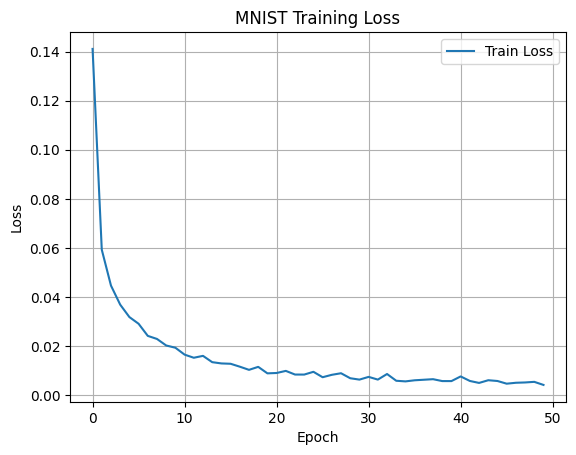

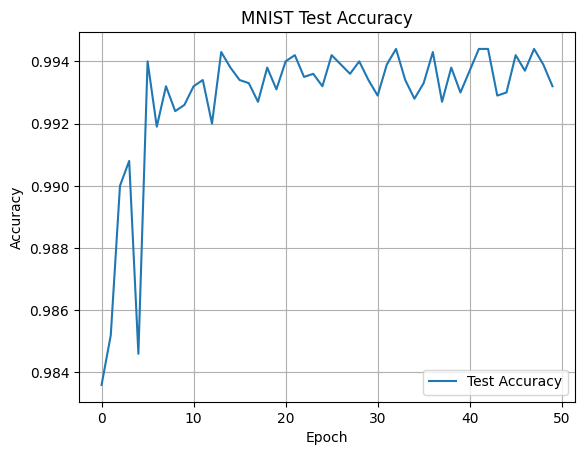

MNIST Evaluation Report:
Accuracy: 0.9932
Precision: 0.9932
Recall: 0.9932
F1-Score: 0.9932

--- Ablation: Running on MNIST Dataset ---
Epoch [1/30], Loss: 0.2636, Test Acc: 0.9750
Epoch [2/30], Loss: 0.0754, Test Acc: 0.9821
Epoch [3/30], Loss: 0.0531, Test Acc: 0.9844
Epoch [4/30], Loss: 0.0413, Test Acc: 0.9891
Epoch [5/30], Loss: 0.0335, Test Acc: 0.9871
Epoch [6/30], Loss: 0.0274, Test Acc: 0.9868
Epoch [7/30], Loss: 0.0238, Test Acc: 0.9878
Epoch [8/30], Loss: 0.0180, Test Acc: 0.9898
Epoch [9/30], Loss: 0.0161, Test Acc: 0.9876
Epoch [10/30], Loss: 0.0133, Test Acc: 0.9878
Epoch [11/30], Loss: 0.0114, Test Acc: 0.9895
Epoch [12/30], Loss: 0.0103, Test Acc: 0.9886
Epoch [13/30], Loss: 0.0091, Test Acc: 0.9897
Epoch [14/30], Loss: 0.0081, Test Acc: 0.9893
Epoch [15/30], Loss: 0.0062, Test Acc: 0.9892
Epoch [16/30], Loss: 0.0057, Test Acc: 0.9883
Epoch [17/30], Loss: 0.0067, Test Acc: 0.9891
Epoch [18/30], Loss: 0.0058, Test Acc: 0.9882
Epoch [19/30], Loss: 0.0028, Test Acc: 0.9888

In [ ]:
datasets = ['ORL', 'MNIST', 'CIFAR']

for name in datasets:
    print(f"\n--- Running on {name} Dataset ---")
    X_train, y_train, X_test, y_test, input_channels, num_classes = load_data(name)

    train_ds = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
    test_ds = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test))

    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

    model = StrongCNN(input_channels, num_classes)
    print(f"{name} label values — min: {y_train.min()}, max: {y_train.max()}, num_classes: {num_classes}")

    trained_model, train_losses, test_accuracies = train_model(model, train_loader, test_loader, epochs=50)

    # Plot training loss
    plt.plot(train_losses, label="Train Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{name} Training Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig(f'/content/drive/MyDrive/ECS189/ECS189G-Project/result/{name}_loss_plot.png')
    plt.show()

    # Plot test accuracy
    plt.plot(test_accuracies, label="Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{name} Test Accuracy")
    plt.legend()
    plt.grid(True)
    plt.savefig(f'/content/drive/MyDrive/ECS189/ECS189G-Project/result/{name}_test_accuracy_plot.png')
    plt.show()

    # Evaluate normal model
    report = evaluate_model(trained_model, test_loader)
    print(f"{name} Evaluation Report:")
    for metric in ["accuracy", "precision", "recall", "f1-score"]:
        avg = report["weighted avg" if metric != "accuracy" else "accuracy"]
        score = avg if metric == "accuracy" else avg[metric]
        print(f"{metric.title()}: {score:.4f}")

    # ⬇️ Paste the ABLATION STUDY here ⬇️
    print(f"\n--- Ablation: Running on {name} Dataset ---")
    ablation_model = AblationCNN(input_channels, num_classes)
    ablation_model, ablation_losses, ablation_test_accuracies = train_model(ablation_model, train_loader, test_loader, epochs=30)

    # Plot ablation loss
    plt.plot(ablation_losses)
    plt.title(f"{name} Ablation Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.savefig(f'/content/drive/MyDrive/ECS189/ECS189G-Project/result/{name}_ablation_loss_plot.png')
    plt.show()

    plt.plot(ablation_test_accuracies, label="Ablation Test Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{name} Ablation Test Accuracy")
    plt.legend()
    plt.grid(True)
    plt.savefig(f'/content/drive/MyDrive/ECS189/ECS189G-Project/result/{name}_ablation_test_accuracy_plot.png')
    plt.show()


    # Evaluate ablation model
    ablation_report = evaluate_model(ablation_model, test_loader)
    print(f"{name} Ablation Evaluation Report:")
    for metric in ["accuracy", "precision", "recall", "f1-score"]:
        avg = ablation_report["weighted avg" if metric != "accuracy" else "accuracy"]
        score = avg if metric == "accuracy" else avg[metric]
        print(f"{metric.title()}: {score:.4f}")